In [ ]:
!pip install deepXDE==0.9

from deepxde.boundary_conditions import DirichletBC
from deepxde.geometry.geometry_2d import Rectangle
from tensorflow.keras.backend import set_floatx
from deepxde.callbacks import EarlyStopping
from deepxde.maps.fnn import FNN
from deepxde.data.pde import PDE
from deepxde.model import Model
from deepxde.backend import tf
import numpy as np
from numpy.random import seed

u0 = 2
set_floatx("float64")

def inlet_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1.0)

def wall_bottom_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0.0)

def wall_right_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1.0)

def wall_left_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

def lid_velocity(x):
    return np.full((x.shape[0],1),u0)


def zero_velocity(x):
    return np.zeros((x.shape[0], 1))

def navier_stokes(x, y, X):
    """Navier-Stokes equation"""
    rho = 1.0
    nu = 0.01

    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]

    du = tf.gradients(u, x)[0]
    dv = tf.gradients(v, x)[0]
    dp = tf.gradients(p, x)[0]

    p_x = dp[:, 0:1]
    p_y = dp[:, 1:2]
    u_x = du[:, 0:1]
    u_y = du[:, 1:2]
    v_x = dv[:, 0:1]
    v_y = dv[:, 1:2]

    u_xx = tf.gradients(u_x, x)[0][:, 0:1]
    u_yy = tf.gradients(u_y, x)[0][:, 1:2]

    v_xx = tf.gradients(v_x, x)[0][:, 0:1]
    v_yy = tf.gradients(v_y, x)[0][:, 1:2]

    continuity = u_x + v_y
    x_momentum = u * u_x + v * u_y + 1 / rho * p_x - nu * (u_xx + u_yy)
    y_momentum = u * v_x + v * v_y + 1 / rho * p_y - nu * (v_xx + v_yy)

    return [continuity, x_momentum, y_momentum]

Compiling model...
Building feed-forward neural network...
'build' took 0.069016 s



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.948773 s

Initializing variables...
Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [1.33e-02, 6.24e-03, 1.30e-02, 4.21e+00, 3.94e-02, 2.42e-03, 1.55e-02, 3.93e-03, 1.07e-02, 2.94e-03, 1.62e-04]    [1.29e-02, 6.45e-03, 1.34e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [4.03e-03, 1.74e-02, 2.69e-03, 3.32e-02, 8.11e-03, 7.20e-02, 4.11e-03, 9.45e-02, 2.49e-03, 2.31e-04, 1.70e-04]    [3.13e-03, 8.24e-03, 2.18e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [3.60e-03, 1.23e-02, 2.54e-03, 3.05e-02, 1.67e-02, 4.96e-02, 5.43e-03, 7.60e-02, 4.38e-03, 9.54e-05, 6.56e-04]    [3.94e-03, 9.11e-03, 2.09e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+0

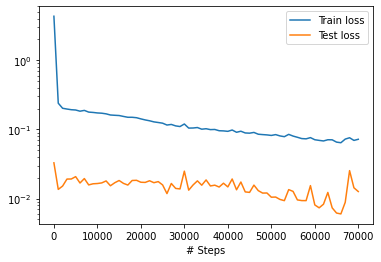

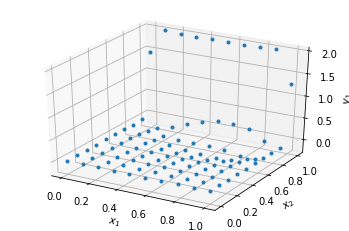

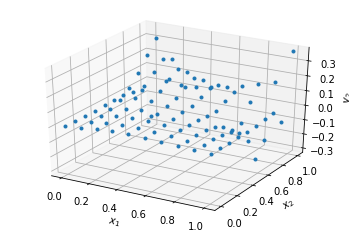

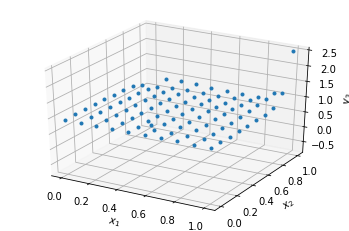

In [ ]:
import deepxde as dde

seed(0)
tf.set_random_seed(0)

if __name__ == '__main__':
    """
    Geometry
    --------
             (0, 1)       (1, 1)
              *------------*
              |            |
              |            |
              |            |
              |            |
         (0,0)*------------*(1, 0)
    """
    geom = Rectangle(
        [0.0, 0.0], [1.0, 1.0]
        )

    inlet_x = DirichletBC(geom, lid_velocity, inlet_boundary,
                          component=0)
    inlet_y = DirichletBC(geom, zero_velocity, inlet_boundary, component=1)
    wall_r_x = DirichletBC(geom, zero_velocity, wall_right_boundary, component=0)
    wall_r_y = DirichletBC(geom, zero_velocity, wall_right_boundary, component=1)
    wall_l_x = DirichletBC(geom, zero_velocity, wall_left_boundary,
                          component=0)
    wall_l_y = DirichletBC(geom, zero_velocity, wall_left_boundary,
                          component=1)
    wall_b_x = DirichletBC(geom, zero_velocity, wall_bottom_boundary,
                          component=0)
    wall_b_y = DirichletBC(geom, zero_velocity, wall_bottom_boundary,
                          component=1)

    data = PDE(        
        geom, navier_stokes,
        [inlet_x, inlet_y, wall_l_x, wall_l_y, wall_r_x,
         wall_r_y,wall_b_x,wall_b_y], num_domain=1000,
        num_boundary=1000, num_test=100
    )

    layer_size = [2] + 4*[50] + [3]

    #layer size #8 230sec 25k
    #layer_size = [2] + 8*[50] + [3]
    activation = "tanh"
    initial = "Glorot uniform"
    optimizer = "adam"
    learning_rate = 0.0005
    net = FNN(layer_size, activation, initial)

    model = Model(data, net)
    model.compile(optimizer, lr=learning_rate)

    early_stopping = EarlyStopping(min_delta=1e-8, patience=4000)
    losshistory,train_state = model.train(epochs=80000, batch_size=32, callbacks=[early_stopping],
                disregard_previous_best=True)
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
import matplotlib.pyplot as plt
sample = 21
x = np.linspace(0,1,sample)
y = np.linspace(0,1,sample)
XX,YY = np.meshgrid(x,y)

up = np.zeros(XX.shape)
vp = np.zeros(XX.shape)
pp = np.zeros(XX.shape)
for i in range(len(XX)):
  z = np.column_stack((XX[i],YY[i]))
  ou = model.predict(z)
  up[i] = ou[:, 0]
  vp[i] = ou[:, 1]
  pp[i] = ou[:, 2]
print(up.shape)

Predicting...
'predict' took 0.065594 s

Predicting...
'predict' took 0.003384 s

Predicting...
'predict' took 0.002798 s

Predicting...
'predict' took 0.003022 s

Predicting...
'predict' took 0.000971 s

Predicting...
'predict' took 0.001158 s

Predicting...
'predict' took 0.001779 s

Predicting...
'predict' took 0.000934 s

Predicting...
'predict' took 0.001407 s

Predicting...
'predict' took 0.001217 s

Predicting...
'predict' took 0.001077 s

Predicting...
'predict' took 0.001614 s

Predicting...
'predict' took 0.000921 s

Predicting...
'predict' took 0.001047 s

Predicting...
'predict' took 0.001667 s

Predicting...
'predict' took 0.001042 s

Predicting...
'predict' took 0.001080 s

Predicting...
'predict' took 0.001116 s

Predicting...
'predict' took 0.001109 s

Predicting...
'predict' took 0.003253 s

Predicting...
'predict' took 0.001361 s

(21, 21)


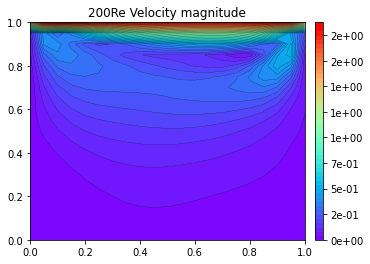

In [ ]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

vel = np.sqrt(up**2+vp**2)
vmin = np.min(vel)
vmax = np.max(vel)
# plot a contour
plt.contour(XX, YY, vel, colors='k', linewidths=0.2, levels=50)
plt.contourf(XX, YY, vel, cmap='rainbow', levels=50, norm=Normalize(vmin=vmin, vmax=vmax))
plt.title('200Re Velocity magnitude')
cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
cbar.mappable.set_clim(vmin, vmax)
plt.savefig('200Re_velocity')

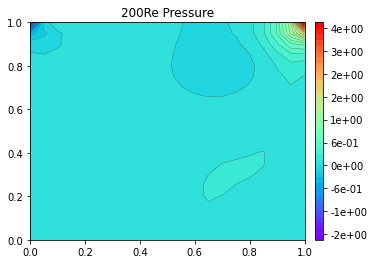

In [ ]:
pmin = np.min(pp)
pmax = np.max(pp)
# plot a contour
plt.contour(XX, YY, pp, colors='k', linewidths=0.2, levels=50)
plt.contourf(XX, YY, pp, cmap='rainbow', levels=50, norm=Normalize(vmin=pmin, vmax=pmax))
plt.title('200Re Pressure')
cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
cbar.mappable.set_clim(pmin, pmax)
plt.savefig('200Re_pressure')

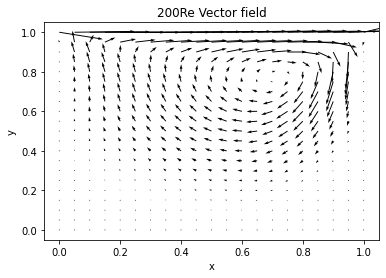

In [ ]:
plt.quiver(XX,YY,up,vp)
plt.title('200Re Vector field')
#model.state_dict()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('200Re_vectorfield_layer')

In [ ]:
cfd = np.load('u2_results.npy')
hiba = cfd-vel

FileNotFoundError: ignored

In [ ]:
vmin = np.min(hiba)
vmax = np.max(hiba)
# plot a contour
plt.contour(XX, YY, hiba, colors='k', linewidths=0.2, levels=50)
plt.contourf(XX, YY, hiba, cmap='rainbow', levels=50, norm=Normalize(vmin=vmin, vmax=vmax))
plt.title('Error of 200Re velocity magnitude')
cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
cbar.mappable.set_clim(vmin, vmax)
plt.savefig('errorOf200Re')

NameError: ignored

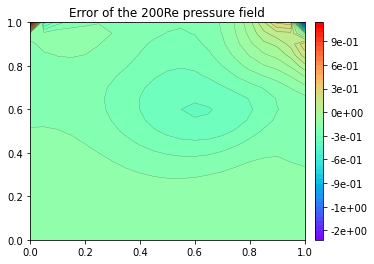

In [ ]:
pcfd = np.load('u2_p.npy')
phiba = pcfd-pp

vmin = np.min(phiba)
vmax = np.max(phiba)
# plot a contour
plt.contour(XX, YY, phiba, colors='k', linewidths=0.2, levels=50)
plt.contourf(XX, YY, phiba, cmap='rainbow', levels=50, norm=Normalize(vmin=vmin, vmax=vmax))
plt.title('Error of the 200Re pressure field')
cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
cbar.mappable.set_clim(vmin, vmax)
plt.savefig('PerrorOf200Re')

In [ ]:
with open('200Re_U.npy','wb') as f:
  np.save(f,up, allow_pickle = False)
with open('200Re_V.npy','wb') as f:
  np.save(f,vp, allow_pickle = False)
with open('200Re_P.npy','wb') as f:
  np.save(f,pp, allow_pickle = False)